# Characterizing the noise in dMRI measurements in multiple b-values

In our [PLoS One article](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0123272) we examined model 
error and compared it to test-retest reliability. We used a standard squared-error loss function (root of the mean squared error, or RMSE). We have been [asked](http://journals.plos.org/plosone/article/comment?id=info%3Adoi%2F10.1371%2Fannotation%2Fdc564667-fa22-4d34-8ff1-09f851c47771) whether using RMSE as a metric is a good idea in cases in which the SNR is low, given that the MRI signal does not always follow a Gaussian distribution.

Issues related to the Rician distribution of MRI, that arises because the MRI magnitude signal is clipped at zero, are already well-known. The original poster points to literature about the noise in places where the signal is essentially zero (the background), but others have already pointed out issues related to locations where the signal is non-zero, and of physiological interest (e.g., Jones and Basser, 2004), such as in the white matter (the region of the brain that we analyzed in our original article). 

Here, we show that the test-retest difference distribution in diffusion MRI data of the white matter very often closely matches a Gaussian distribution. We then demonstrate that even when compared to a true Gausssian distribution, the RMSE deviates from the expectation by no more than about 15%. Finally, we show that the noise is more-or-less IID, and that the signal does not seem to hit the noise floor very often (in less than <3% of the mesaruements, even for the highest b-value used here).

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Download data:

Data acquisition and pre-processing are described in our article. Briefly: data were collected at 2 mm isotropic resolution, and three different b-values: 1000, 2000, and 4000 $s/mm^2$. We analyze here the data from one individual. In addition, we download a segmentation of this individuals brain, conducted using Freesurfer (Fischl, 2012). We will use this segmentation to identify the parts of the image that contain the white matter.

In [2]:
import urllib as url
import os.path as op

top_url = 'https://stacks.stanford.edu/file/druid:ng782rw8378/'

# Download test-retest data in 3 b-values
for s in [1, 2]:
    for b in [1000, 2000, 4000]:
        for ext in ['.nii.gz', '.bvecs', '.bvals']:
            fname = 'SUB1_b%s_%s%s'%(b,s, ext)
            if not op.exists('./data/' + fname):
                url.request.urlretrieve(op.join(top_url, fname), './data/' + fname)
    
# Download a white matter segmentation:
for fname in ["SUB1_aparc-reduced.nii.gz", "SUB1_t1.nii.gz"]:
    if not op.exists('./data/' + fname):
        url.request.urlretrieve(op.join(top_url, fname), './data/' + fname)


### Create a mask of white matter from the Freesurfer segmentation:

In [3]:
seg_img = nib.load('data/SUB1_aparc-reduced.nii.gz')
seg = seg_img.get_data()
# Detect the white matter portions as a mask: 
mask = (seg == 1) | (seg == 2)

In [4]:
import nibabel as nib
import dipy.core.gradients as dpg
from scipy import stats

### Define a couple of utility functions:

In [5]:
# This is used to resample the white matter mask to the resolution 
# of the DWI data:

from dipy.align.imaffine import AffineMap

def resample_volume(moving, static):
    """ 
    Resample a nifti image into the space of another nifti image
    
    Parameters
    ----------
    moving : Nifti1Image
        The 'source' image.
    static : Nifti1Image
        The 'target' image.
        
    Returns
    -------
    resampled_img : Nifti1Image
       The source data in the target space, with the target affine
    """
    affine_map = AffineMap(np.eye(4),
                           static.shape[:3], static.affine, 
                           moving.shape, moving.affine)
    
    resampled = affine_map.transform(moving.get_data())
    return nib.Nifti1Image(resampled, static.get_affine())


In [6]:
# Read data from files
def load_data(b):
    """ Read test-retest dMRI data from files"""
    gtab1 = dpg.gradient_table('data/SUB1_b%s_1.bvals'%b, 
                              'data/SUB1_b%s_1.bvecs'%b)

    gtab2 = dpg.gradient_table('data/SUB1_b%s_2.bvals'%b, 
                              'data/SUB1_b%s_2.bvecs'%b)

    img1 = nib.load('data/SUB1_b%s_1.nii.gz'%b)
    img2 = nib.load('data/SUB1_b%s_2.nii.gz'%b)

    data1 = img1.get_data()
    data2 = img2.get_data()
    
    return gtab1, gtab2, data1, data2

In [7]:
# Utility function to set the size of figures, add a
# grid and 
def prettify(fig_list, ax_list):
    for fig, ax in zip(fig_list, ax_list):
        fig.set_size_inches([8, 8])
        ax.grid("on", linestyle="--")
        ax.legend()

In [8]:
# Calculate the root of the mean of the squared error between two signals
def rmse(data, pred):
    result = np.sqrt(np.mean((data - pred) ** 2, -1))
    result[np.isnan(result)] = 0
    return result

### Resample the T1-weighted volume to the DWI resolution:

In [9]:
t1_img = nib.load('data/SUB1_t1.nii.gz')
t1_resamp = resample_volume(t1_img, nib.load('data/SUB1_b1000_1.nii.gz'))
t1 = t1_resamp.get_data()

### Refine the WM mask using the distribution of mean diffusivity:

To avoid including voxels that contain partial volume of CSF, we further refine the white matter mask, based on the distribution of MD. This is based on the procedure used by Jeurissen et al. (2012). As in our original paper, we use the measurement at b=2000 $s/mm^2$.

In [10]:
import dipy.reconst.dti as dti
gtab1, gtab2, data1, data2 = load_data(2000)

ten_model = dti.TensorModel(gtab1)
ten_fit = ten_model.fit(data1, mask=mask)

In [11]:
MD = ten_fit.md

In [12]:
IQR = (stats.scoreatpercentile(MD[mask], 75) -
       stats.scoreatpercentile(MD[mask], 25))
co = np.median(MD[mask]) + 2 * IQR
co_idx = np.where(MD > co)

In [13]:
new_mask = np.copy(mask)
new_mask[co_idx] = 0
mask = new_mask

### Characterize the signals

First, we plot the distributions of signals in these data. This is done as a sanity check that the signal does indeed distribute following the expected Rician distribution.

For each voxel, we extract the diffusion-weighted signals (relative to the non diffusion-weighted signal) and we plot the distribution of these across all directions and all voxels in the white matter.

We also want to characterize the Gaussianity of the signals, so we plot the distribution of the excess kurtosis in each voxel:

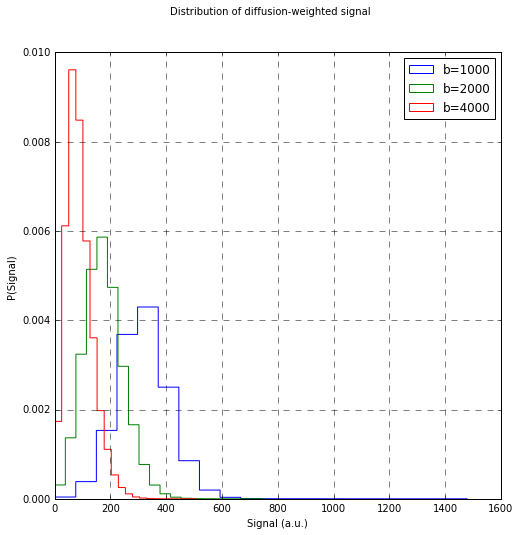

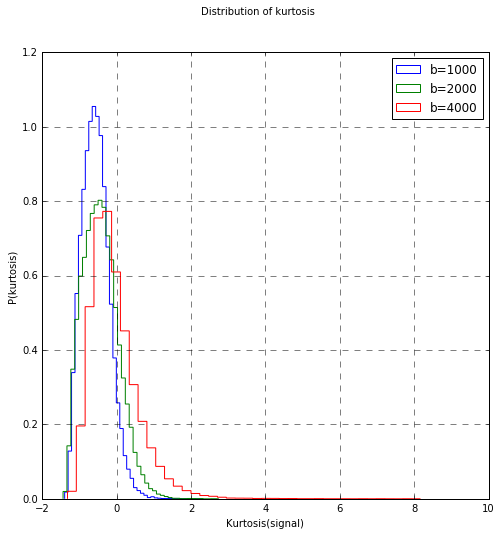

In [14]:
fig_sig, ax_sig = plt.subplots(1)
fig_kurt, ax_kurt = plt.subplots(1)

for b in [1000, 2000, 4000]:
    gtab1, gtab2, data1, data2 = load_data(b)
    sig_d = (data1[..., ~gtab1.b0s_mask])# / 
            #(np.mean(data1[..., gtab1.b0s_mask], -1)[..., None]))

    # Relative diffusion-weighted signal larger than 1 is an artifact:
    #sig_d[sig_d > 1] = 1

    # Histogram of the diffusion-weighted normalized signals:
    ax_sig.hist(sig_d[mask].ravel(), 
                 histtype='step', bins=20, normed=True, label='b=%s'%b)
    
    ax_sig.set_xlabel("Signal (a.u.)")
    ax_sig.set_ylabel("P(Signal)")
    fig_sig.suptitle("Distribution of diffusion-weighted signal")

    # And the kurtosis:
    ax_kurt.hist(stats.kurtosis(sig_d[mask], -1), 
                 histtype='step', bins=40, normed=True, label='b=%s'%b)
    
    ax_kurt.set_xlabel("Kurtosis(signal)")
    ax_kurt.set_ylabel("P(kurtosis)")
    fig_kurt.suptitle("Distribution of kurtosis")

prettify([fig_sig, fig_kurt], [ax_sig, ax_kurt])

### Characterizing the distribution of errors

One way to address the question of whether the errors are distributed in a Gaussian manner is to assess the kurtosis of the test-retest differences in each voxel. In voxels in which this distribution is Gaussian, the excess kurtosis will be approximately 0. 

We also want to know whether there are parts of the white matter that are particularly susceptible to large deviations  from Gaussian. 

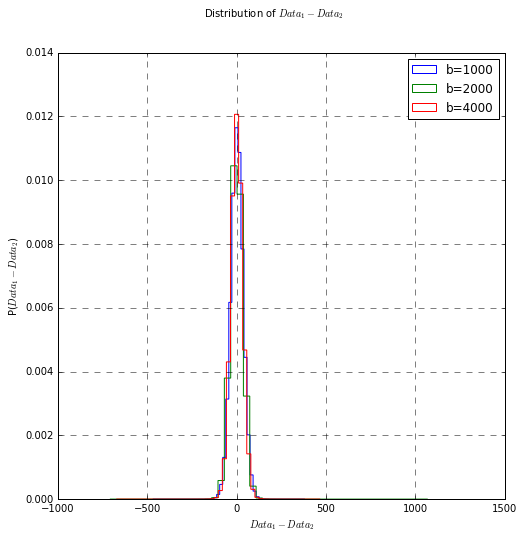

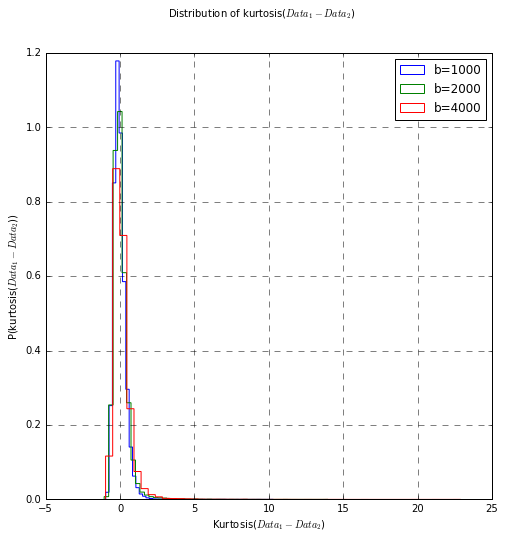

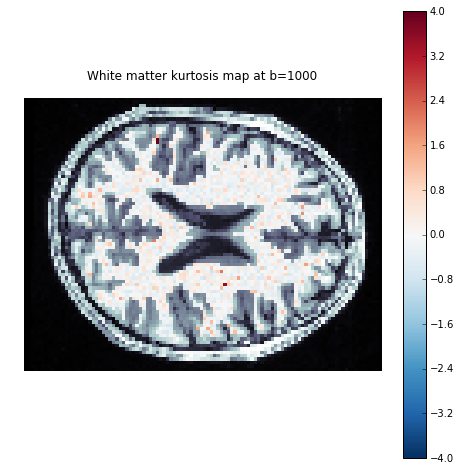

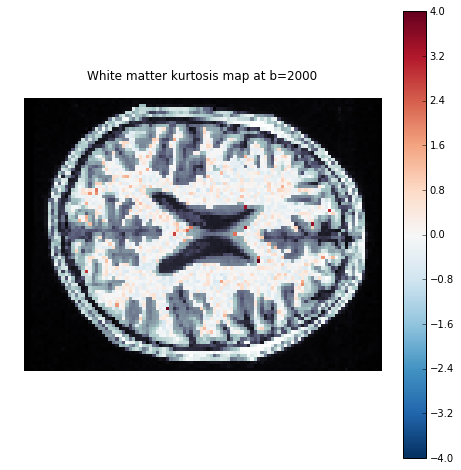

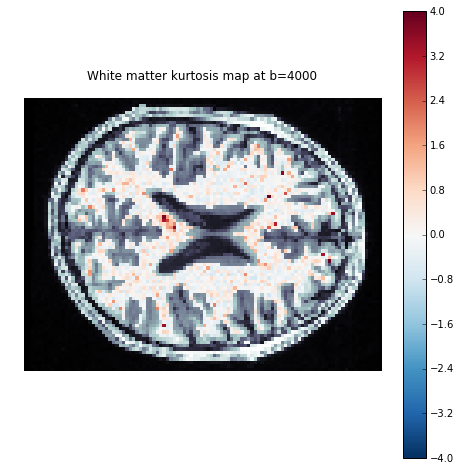

In [15]:
fig_diff, ax_diff = plt.subplots(1)
fig_kurtosis, ax_kurtosis = plt.subplots(1)

for b in [1000, 2000, 4000]:
    gtab1, gtab2, data1, data2 = load_data(b)
    # Calculate the measurement-by-measurement test-retest 
    # reliability:
    diff = data1[mask] - data2[mask]
    # Histogram of the differences:
    ax_diff.hist(diff.ravel(), histtype='step', bins=50, 
                 normed=True, label='b=%s'%b)
    ax_diff.set_xlabel("$Data_1 - Data_2$")
    ax_diff.set_ylabel("P($Data_1 - Data_2$)")
    fig_diff.suptitle("Distribution of $Data_1 - Data_2$")
    
    k = stats.kurtosis(diff, axis=-1)
    ax_kurtosis.hist(k, bins=50, normed=True, histtype='step',
                     label='b=%s'%b)
    
    ax_kurtosis.set_xlabel("Kurtosis($Data_1 - Data_2$)")
    ax_kurtosis.set_ylabel("P(kurtosis($Data_1 - Data_2$))")
    fig_kurtosis.suptitle("Distribution of kurtosis($Data_1 - Data_2$)")

    # What is the spatial distribution of the kurtosis?
    vol = np.ones(mask.shape[:3]) * np.nan
    vol[mask] = k
    fig, ax = plt.subplots(1)
    ax.matshow(t1[:, :, 40], cmap='bone')
    im = ax.matshow(vol[:, :, 40], vmin=-4, vmax=4, cmap='RdBu_r')
    plt.colorbar(im)
    fig.set_size_inches([8, 8])
    ax.set_title("White matter kurtosis map at b=%s"%b)
    ax.set_axis_off()

prettify([fig_diff, fig_kurtosis], [ax_diff, ax_kurtosis])

### Compare to data with a true Gaussian distribution of noise

What would happen if the data really did have Gaussian noise? We can simulate this situation by sampling a noise 
for every measurement taken from a Gaussian distribution with the same standard deviation as the (non-Gaussian) noise in the measured data. We can then compare RMSE of model prediction in the two cases: true Gaussian, and measured data noise distribution. We do that below. 

/Users/arokem/source/dipy/dipy/reconst/dti.py:1787: RuntimeWarning: divide by zero encountered in log
  D[..., 6] = -np.log(b0)
/Users/arokem/source/dipy/dipy/reconst/dti.py:1787: RuntimeWarning: invalid value encountered in log
  D[..., 6] = -np.log(b0)
/Users/arokem/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/arokem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


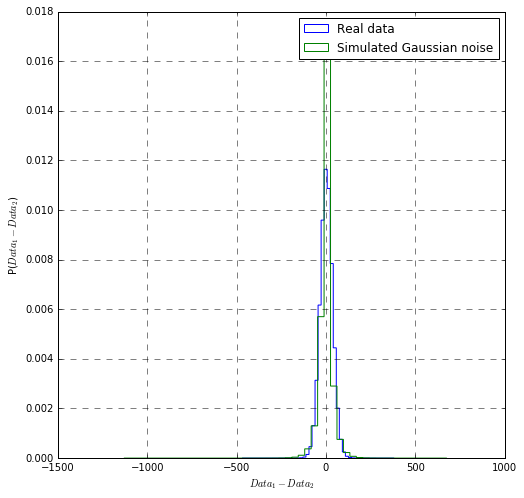

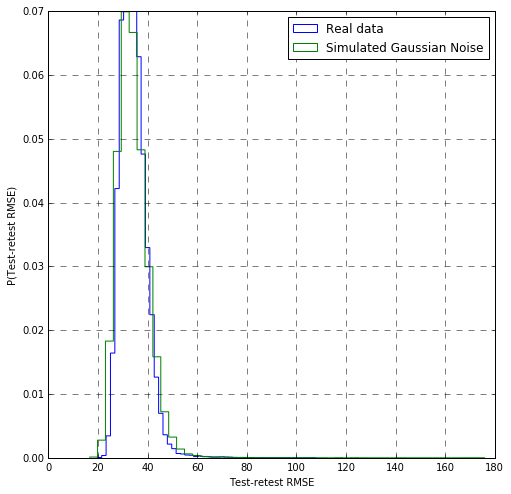

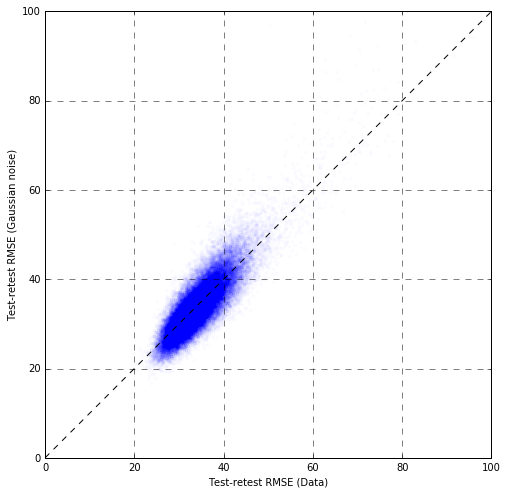

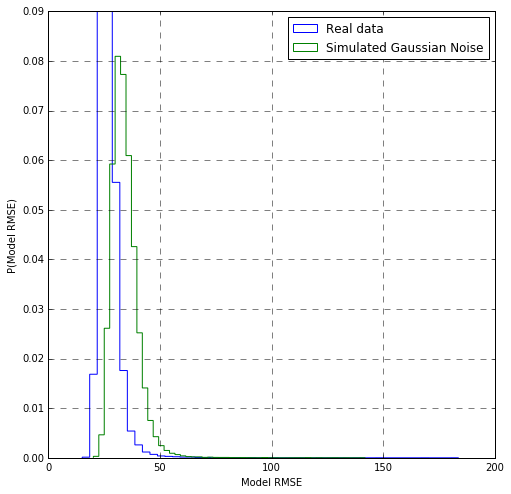

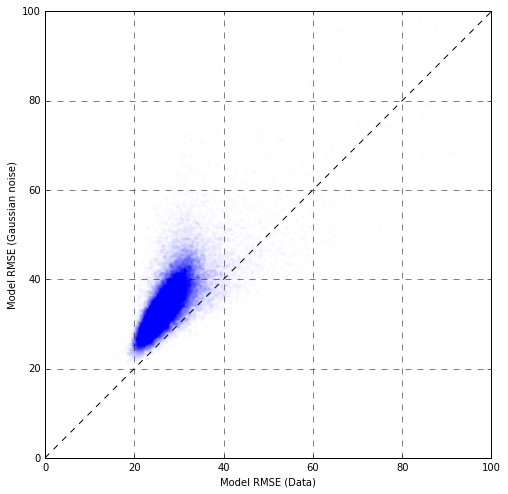

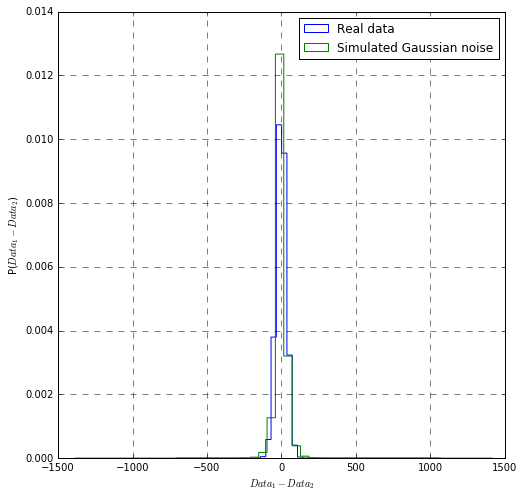

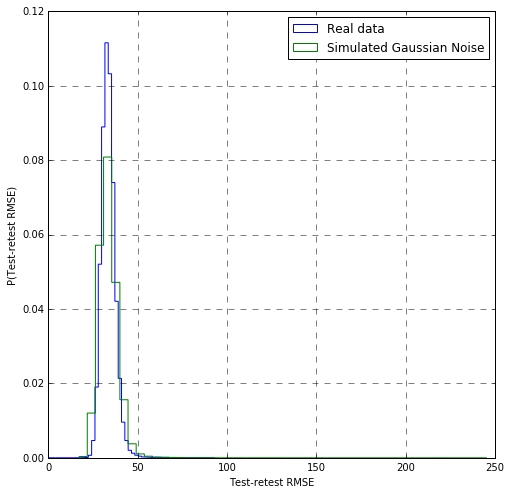

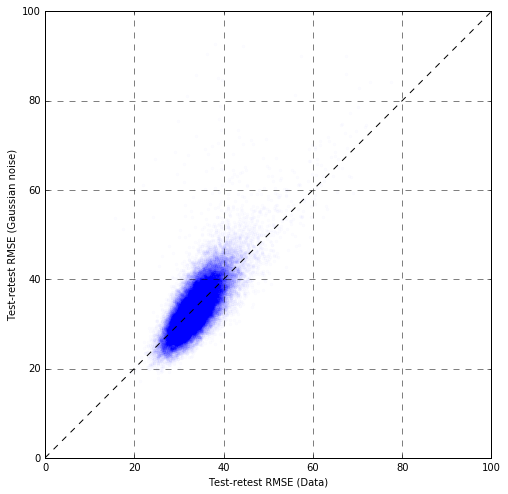

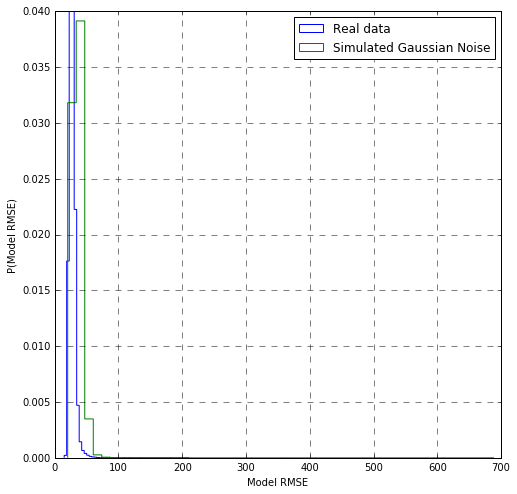

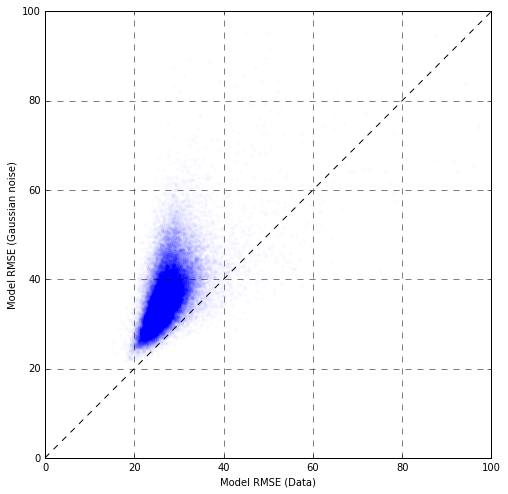

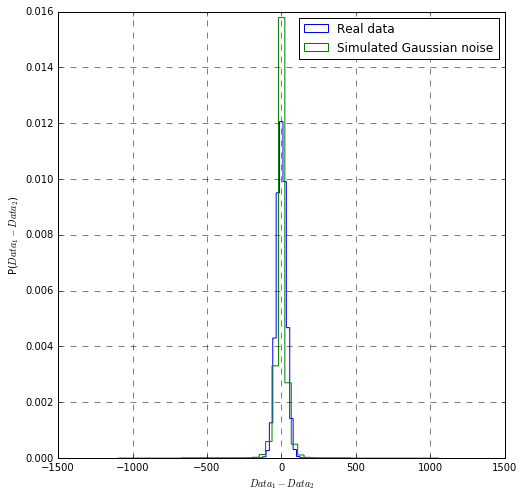

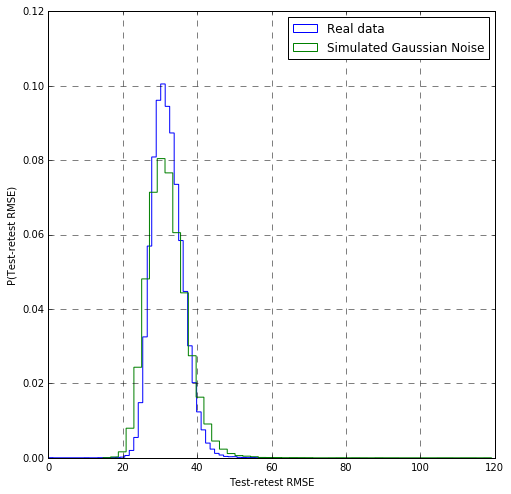

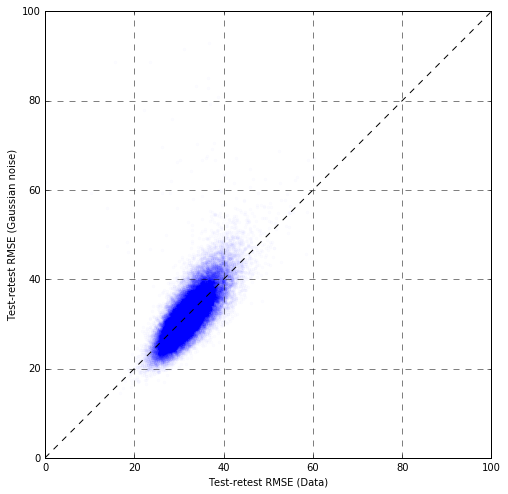

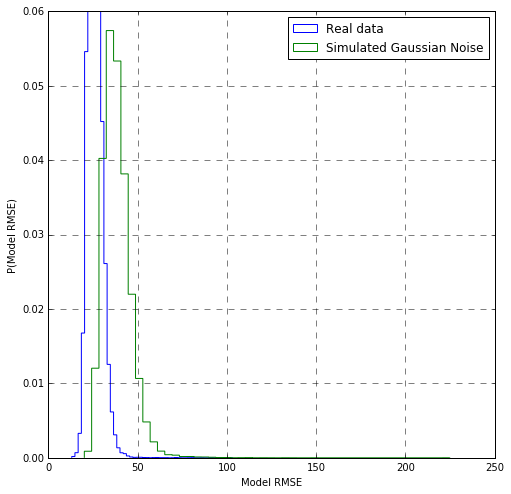

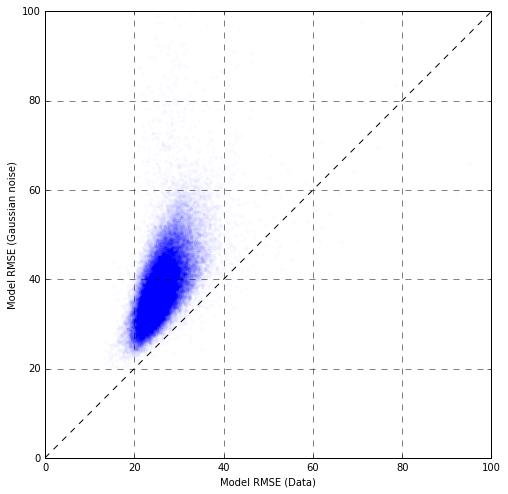

In [16]:
for idx, b in enumerate([1000, 2000, 4000]):
    # As before:
    gtab1, gtab2, data1, data2 = load_data(b)
    diff = data1[mask] - data2[mask]
    
    # Simulate data with true Gaussian noise:
    gauss = np.random.randn(*data1.shape)
    noise = np.sqrt((data1.astype(float) - data2.astype(float)) ** 2)
    data_gaussian_noise = data1 + noise * gauss
    diff_gaussian = data1[mask] - data_gaussian_noise[mask]
    
    # Plot the difference distributions together:
    fig_hist_gaussian, ax_hist_gaussian = plt.subplots(1)
    ax_hist_gaussian.hist(diff.ravel(), histtype='step', 
                          bins=50, normed=True, label="Real data")
    ax_hist_gaussian.hist(diff_gaussian.ravel(), histtype='step', 
                          bins=50, normed=True, label="Simulated Gaussian noise")
    ax_hist_gaussian.set_xlabel("$Data_1 - Data_2$")
    ax_hist_gaussian.set_ylabel("P($Data_1 - Data_2$)")
    
    # Calculate test-retest reliability:
    trt_data = rmse(data1[mask], data2[mask])
    trt_gaussian = rmse(data1[mask], data_gaussian_noise[mask])
    fig_trt, ax_trt = plt.subplots(1)
    ax_trt.hist(trt_data, histtype='step', 
                 bins=50, normed=True, label="Real data")
    ax_trt.hist(trt_gaussian, histtype='step',
                 bins=50, normed=True, label="Simulated Gaussian Noise")
    
    ax_trt.set_xlabel("Test-retest RMSE")
    ax_trt.set_ylabel("P(Test-retest RMSE)")

    # Plot voxel-by-voxel test-retest:
    fig_trt_scatter, ax_trt_scatter = plt.subplots(1)
    ax_trt_scatter.plot(trt_data, trt_gaussian, '.', alpha=0.01)
    ax_trt_scatter.plot([0, 100], [0, 100], 'k--')
    ax_trt_scatter.set_xlim([0, 100])
    ax_trt_scatter.set_ylim([0, 100])    
    ax_trt_scatter.set_xlabel("Test-retest RMSE (Data)")
    ax_trt_scatter.set_ylabel("Test-retest RMSE (Gaussian noise)")

    
    # Fit the tensor model:
    dtm1 = dti.TensorModel(gtab1)
    dtm2 = dti.TensorModel(gtab2)
    dtf1 = dtm1.fit(data1, mask)
    dtf2 = dtm2.fit(data2, mask)    
    dtf_gaussian_noise = dtm1.fit(data_gaussian_noise, mask)

    # Predict from each model fit:
    p1_2 = dtf1.predict(gtab2, np.mean(data1[..., gtab1.b0s_mask], -1))
    p2_1 = dtf2.predict(gtab1, np.mean(data2[..., gtab2.b0s_mask], -1))
    p1_noise = dtf1.predict(gtab1, np.mean(data1[..., gtab1.b0s_mask], -1))
    pnoise_1 = dtf_gaussian_noise.predict(gtab1, np.mean(data_gaussian_noise[..., gtab1.b0s_mask], -1))
    
    # Calculate the RMSE in both directions (as in equation 10 in our paper):
    rmse_data = (rmse(data2[mask], p1_2[mask]) + 
                 rmse(data1[mask], p2_1[mask])) / 2 
    
    rmse_gaussian_noise = (rmse(data_gaussian_noise[mask], p1_noise[mask]) +
                           rmse(data1[mask], pnoise_1[mask])) / 2 

    fig_rmse, ax_rmse = plt.subplots(1)
    ax_rmse.hist(rmse_data, histtype='step', 
                 bins=50, normed=True, label="Real data")
    ax_rmse.hist(rmse_gaussian_noise, histtype='step',
                 bins=50, normed=True, label="Simulated Gaussian Noise")

    ax_rmse.set_xlabel('Model RMSE')
    ax_rmse.set_ylabel('P(Model RMSE)')

    fig_rmse_scatter, ax_rmse_scatter = plt.subplots(1)
    ax_rmse_scatter.plot(rmse_data, rmse_gaussian_noise, '.', alpha=0.01)
    ax_rmse_scatter.plot([0, 100], [0, 100], 'k--')
    ax_rmse_scatter.set_xlim([0, 100])
    ax_rmse_scatter.set_ylim([0, 100])    
    ax_rmse_scatter.set_xlabel("Model RMSE (Data)")
    ax_rmse_scatter.set_ylabel("Model RMSE (Gaussian noise)")    
    
    prettify([fig_hist_gaussian, fig_rmse, fig_diff, fig_rmse_scatter, fig_trt, fig_trt_scatter], 
             [ax_hist_gaussian, ax_rmse, ax_diff, ax_rmse_scatter, ax_trt, ax_trt_scatter])

## Simulate data with the different noise distributions:

Here, instead of using the original data to fit the model, we first generate "simulated" data that has one of two noise distributions: 

1. Test-retest noise based on the difference between measurement #1 and measurement #2
2. Gaussian noise with the same variance as #1.

These data have a ground truth of a tensor, so the true model is always the tensor.


/Users/arokem/source/dipy/dipy/reconst/dti.py:1787: RuntimeWarning: divide by zero encountered in log
  D[..., 6] = -np.log(b0)
/Users/arokem/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


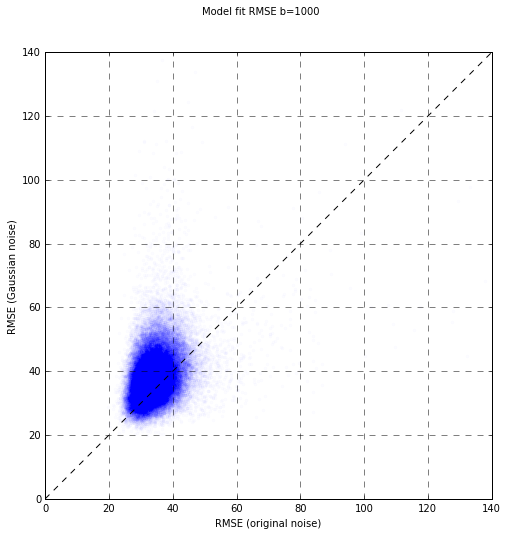

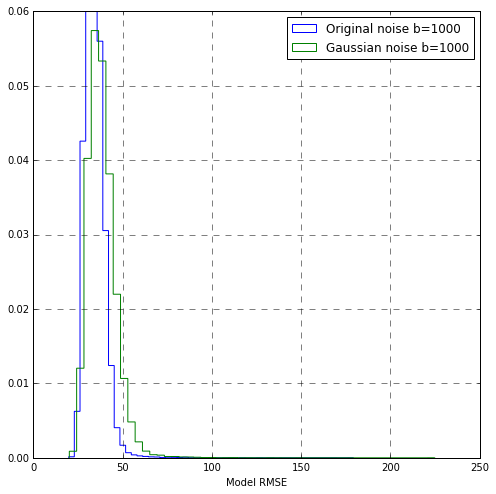

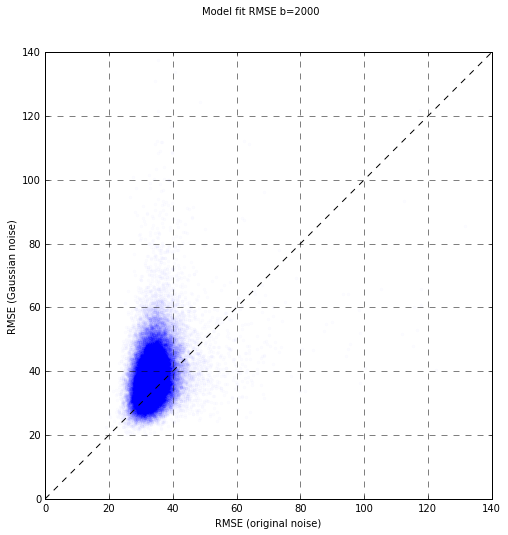

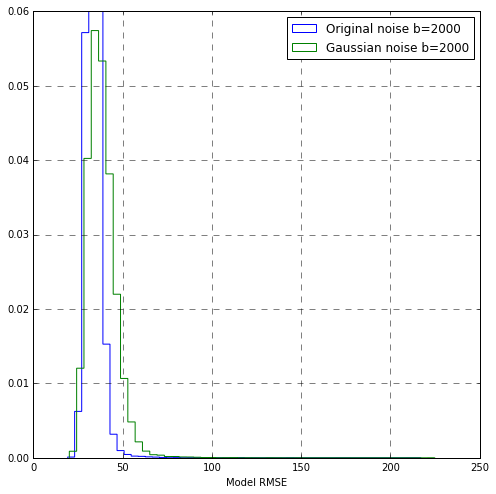

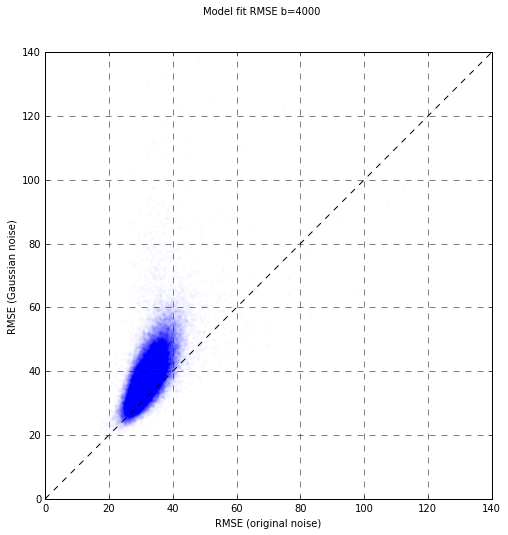

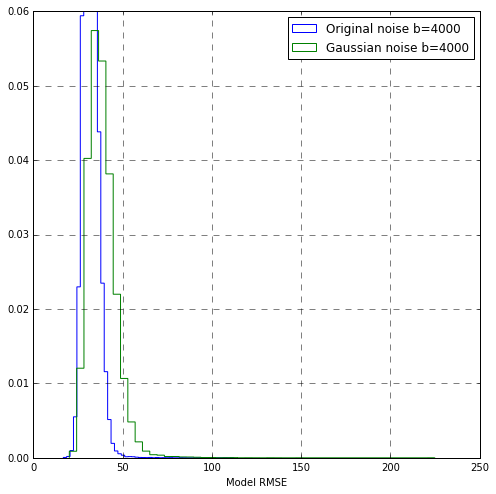

In [17]:
for idx, b in enumerate([1000, 2000, 4000]):
    # As before:
    gtab1, gtab2, data1, data2 = load_data(b)
    # Simulate a tensor, by fitting to the data and then predicting with 
    # the tensor model in each voxel:
    dtm1 = dti.TensorModel(gtab1)
    dtf1 = dtm1.fit(data1, mask)

    # Derive the tensor prediction. We'll use this as "ground truth"
    p1 = dtf1.predict(gtab1, np.mean(data1[..., gtab1.b0s_mask], -1))

    # Data with the addition of the original noise:
    data_noise = p1 + (data1 - data2)

    # Noise variance in each voxel:
    noise = np.sqrt((data1.astype(float) - data2.astype(float)) ** 2)

    # Data with Gaussian-generated noise
    data_gaussian_noise = p1 + noise * gauss

    # Fit to both kinds of data:
    dtf_noise = dtm1.fit(data_noise, mask)
    dtf_gaussian_noise = dtm1.fit(data_gaussian_noise, mask)
    
    # Check the model fits relative to ground truth data:
    p_noise = dtf_noise.predict(gtab1, np.mean(data1[..., gtab1.b0s_mask], -1))
    p_gaussian_noise = dtf_gaussian_noise.predict(gtab1, np.mean(data1[..., gtab1.b0s_mask], -1))
    rmse_noise = rmse(p1[mask], data_noise[mask])
    rmse_gaussian = rmse(p1[mask], data_gaussian_noise[mask])
    
    # Plot voxel-by-voxel comparisons:
    fig1, ax1 = plt.subplots(1)
    plt.plot(rmse_noise, rmse_gaussian_noise, '.', alpha=0.01)
    plt.plot([0, 140], [0, 140], 'k--')
    ax1.set_xlim([0, 140])
    ax1.set_ylim([0, 140])
    ax1.set_xlabel('RMSE (original noise)')
    ax1.set_ylabel('RMSE (Gaussian noise)')
    fig1.suptitle("Model fit RMSE b=%s"%b)
    
    # And the overall distributions:
    fig2, ax2 = plt.subplots(1)
    ax2.hist(rmse_noise, bins=50, normed=True, histtype='step',
            label='Original noise b=%s'%b)

    ax2.hist(rmse_gaussian_noise, bins=50, normed=True, histtype='step',
            label='Gaussian noise b=%s'%b)

    ax2.set_xlabel("Model RMSE")    
    prettify([fig1, fig2], [ax1, ax2])

### Is it reasonably IID?

Another aspect of using RMSE is that we would ideally want all the signals to be IID. 

Here, we examine whether there is a systematic dependence between the mean signal (across the two measurements) and the standard deviation of this. 

We can see that really low signals do have squashed distributions (when the signal is 0, the STD is also essentially 0), but that affects only a small range of signal values.


(0, 1500)

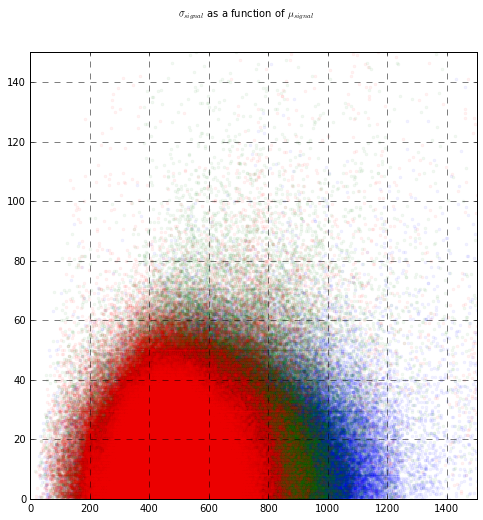

In [18]:
fig_scatter, ax_scatter = plt.subplots(1)

for b in [1000, 2000, 4000]:
    gtab1, gtab2, data1, data2 = load_data(b)
    stack_data = np.vstack([data1[..., gtab1.b0s_mask][mask].ravel(), 
                            data2[..., gtab2.b0s_mask][mask].ravel()])

    std_data = np.std(stack_data, 0)
    mean_data = np.mean(stack_data, 0)
    
    # Is there a systematic relationship between standard deviation 
    # and mean signal?
    ax_scatter.plot(mean_data, std_data, '.', alpha=0.05)
    
    fig_scatter.suptitle("$\sigma_{signal}$ as a function of $\mu_{signal}$")
    
fig_scatter.set_size_inches([8, 8])
ax_scatter.grid("on", linestyle="--")

# Zoom in on the part that contains most of the data:
ax_scatter.set_ylim([0, 150])
ax_scatter.set_xlim([0, 1500])

### Is it hitting the noise floor?

Finally, the RMSE would be overly optimistic in cases where the measurement is so close to zero as to be indistinguishable from noise. This can be tested by estimating the noise from the b=0 measurements and asking what 
proportion of the measurements in the white matter is below this estimate of the noise.

In [19]:
for b in [1000, 2000, 4000]:
    gtab1, gtab2, data1, data2 = load_data(b)
    noise1 = np.std(data1[mask][:, gtab1.b0s_mask], -1)
    print(np.mean(data1[mask][:, ~gtab1.b0s_mask] < np.median(noise1)))
    noise2 = np.std(data2[mask][:, gtab2.b0s_mask], -1)
    print(np.mean(data2[mask][:, ~gtab2.b0s_mask] < np.median(noise2)))

7.50192932393e-05
8.37535969179e-05
0.00257362838529
0.00279318245721
0.0263338059429
0.0268133551093


### References 

1. Jones D and Basser P.J. (2004). “Squashing Peanuts and Smashing Pumpkins”: How
   Noise Distorts Diffusion-Weighted MR Data. Magnetic Resonance in Medicine 52:979-993.
2. Fischl, B. (2012). FreeSurfer. Neuroimage, 62(2):774–781.
3. Jeurissen B, Leemans A, Tournier, J-D, Jones, DK and Sijbers J
   (2013). Investigating the prevalence of complex fiber configurations in white
   matter tissue with diffusion magnetic resonance imaging. Human Brain Mapping  
   34:2747-2766, doi: 10.1002/hbm.2209